# Risk Analysis

The purpose of this section is to combine the CitiBike trip data with the NYC collision data to perform a risk analysis. The goal is two-fold:
1. Get a measure of risky stations
    - This can be used to warn users about to start their ride from a risky station.
    - Making risk salient may make users extra careful when riding and reduce the accident rate.
2. Create a model capable of predicting the risk associated with a ride from a particular station at a particular time.
    - Such a model is helpful for an insurance company to assess risk when providing ride insurance.
    - In turn, this may be integrated into the pricing strategy, so that the insurance pricing can depend on the station and time.

In [2]:
# Imports
import pandas as pd
import numpy as np
import duckdb
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import branca.colormap as cm

sns.set_style("whitegrid")

DATA_PATH = "../data/processed/citibike/*/*/data.parquet"
con = duckdb.connect("../data/processed/citibike/citibike.duckdb")

def period_of_day(hour: int) -> str:
    if 6 <= hour < 10:
        return "Morning"
    elif 10 <= hour < 16:
        return "Midday"
    elif 16 <= hour < 20:
        return "Evening"
    elif 20 <= hour < 24:
        return "Late Evening"
    else:
        return "Night"



## 1. Risk measure of stations

In [4]:
# Load station data
stations = con.execute("""
WITH trips AS (
    SELECT
        start_station_id,
        start_station_name,
        start_lat, start_lng,
        end_station_id,
        end_station_name,
        end_lat, end_lng
    FROM read_parquet($data_path)
),
stations_union AS (
    SELECT start_station_id AS station_id, start_station_name AS station_name,
           start_lat AS lat, start_lng AS lon
    FROM trips
    WHERE start_station_id IS NOT NULL

    UNION

    SELECT end_station_id AS station_id, end_station_name AS station_name,
           end_lat AS lat, end_lng AS lon
    FROM trips
    WHERE end_station_id IS NOT NULL
)
SELECT DISTINCT
    CAST(station_id AS VARCHAR) AS station_id,
    station_name,
    ROUND(lat::DOUBLE, 5) AS lat,
    ROUND(lon::DOUBLE, 5) AS lon
FROM stations_union
ORDER BY station_id
""", {"data_path": DATA_PATH}).df()

# Load cleaned collision data
collision = pd.read_csv("../data/processed/cleaned_collision_data.csv")
collision["CRASH DATETIME"] = pd.to_datetime(collision["CRASH DATETIME"], errors="coerce")

# BallTree spatial match
stations_rad = np.radians(stations[["lat", "lon"]].values)
tree = BallTree(stations_rad, metric="haversine")

crash_coords = np.radians(collision[["LATITUDE", "LONGITUDE"]].values)
dist, idx = tree.query(crash_coords, k=1)

collision["nearest_station_id"] = stations.iloc[idx.flatten()].station_id.values
collision["distance_m"] = dist * 6371000  # Convert from radians to meters

# Risk score calculation
alpha = 0.10

# Filter collisions within 300m of a station
df_station = collision.query("distance_m <= 300").copy()

# Per-crash risk scores
df_station["risk_cyclist"] = (
    df_station["CYCLIST_INVOLVED"] *
    (1 + 10*df_station["NUMBER OF PERSONS INJURED"]
       + 100*df_station["NUMBER OF PERSONS KILLED"])
)

df_station["risk_non_cyclist"] = (
    (1 - df_station["CYCLIST_INVOLVED"]) *
    (1 + 10*df_station["NUMBER OF PERSONS INJURED"]
       + 100*df_station["NUMBER OF PERSONS KILLED"])
)

# Aggregate risk per station
risk_raw = (df_station
            .groupby("nearest_station_id")[["risk_cyclist","risk_non_cyclist"]]
            .sum()
            .reset_index())

# Normalize risk scores
risk_raw["risk_cyclist_norm"] = risk_raw["risk_cyclist"] / risk_raw["risk_cyclist"].max()
risk_raw["risk_non_cyclist_norm"] = risk_raw["risk_non_cyclist"] / risk_raw["risk_non_cyclist"].max()

# Composite normalized risk score
risk_raw["risk_norm"] = ((1-alpha)*risk_raw["risk_cyclist_norm"] +
                          alpha*risk_raw["risk_non_cyclist_norm"])

stations_with_risk = (
    stations.merge(risk_raw, left_on="station_id", right_on="nearest_station_id", how="left")
            .fillna({"risk_cyclist_norm": 0, "risk_non_cyclist_norm": 0, "risk_norm": 0})
)

To obtain a station-level indicator of cyclist crash risk, we combine NYPD collision data with CitiBike station locations and trip data. Using a spatial matching approach based on a Haversine-distance BallTree, we assign each crash to its nearest station within a 300-meter radius and compute a severity-weighted risk score for each location. This procedure produces a measure of relative safety across the CitiBike network.

After linking crashes to stations, we translate each incident into a severity score that captures not just the presence of a cyclist but also whether injuries or fatalities occurred. Aggregating these scores at the station level gives a raw measure of crash severity exposure. Because crash events are rare and highly skewed, we normalize these station totals to the [0,1] range to facilitate comparison across the network.

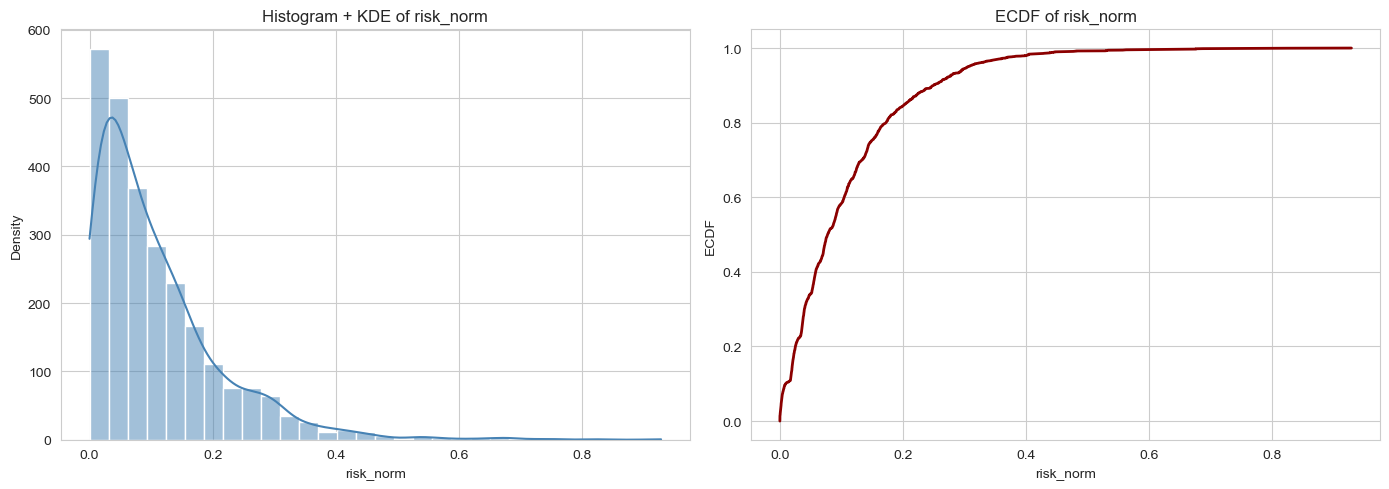

In [5]:
# Visualize the distribution of risk_norm
vals = stations_with_risk["risk_norm"].values


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --------------------------------------------
# LEFT: Histogram + KDE
# --------------------------------------------
sns.histplot(vals, bins=30, kde=True, ax=axes[0], color="steelblue")
axes[0].set_xlabel("risk_norm")
axes[0].set_ylabel("Density")
axes[0].set_title("Histogram + KDE of risk_norm")

# --------------------------------------------
# RIGHT: ECDF
# --------------------------------------------
sorted_vals = np.sort(vals)
ecdf = np.linspace(0, 1, len(sorted_vals))

axes[1].plot(sorted_vals, ecdf, color="darkred", lw=2)
axes[1].set_xlabel("risk_norm")
axes[1].set_ylabel("ECDF")
axes[1].set_title("ECDF of risk_norm")
axes[1].grid(True)

plt.tight_layout()
plt.show()



The resulting distribution of normalized risk scores is heavily right-skewed: most stations experience essentially no cyclist-involved activity, while a small number of stations form a clear upper tail of risk. Plotting both a histogram with a KDE and an empirical CDF reveals that only a small subset of stations contribute meaningfully to the high-risk regions of the city. This suggests that risk is highly localized and that targeted interventions could be more effective than uniform city-wide policies.

In [6]:
risky_threshold = stations_with_risk["risk_norm"].quantile(0.95)
risky = stations_with_risk.loc[stations_with_risk["risk_norm"] >= risky_threshold].copy()

df = risky  # only the filtered stations

center_lat = df["lat"].mean()
center_lon = df["lon"].mean()
fig = folium.Figure(width="60%", height="450px")
m = folium.Map(location=[center_lat, center_lon],
               zoom_start=12,
               tiles="cartodbpositron")
fig.add_child(m)

MAX_RADIUS = 40
colormap = cm.linear.Reds_09.scale(0, 1)

for _, row in df.iterrows():
    radius = max(MAX_RADIUS * row["risk_norm"], 4)
    color = colormap(row["risk_norm"])
    
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>{row['station_name']}</b><br>"
            f"risk: {row['risk_norm']:.3f}<br>",
            max_width=250,
        ),
    ).add_to(m)

m


Given the strong concentration of risk in the upper tail, it is natural to focus attention on the highest-risk stations. Using the empirical distribution, we select the top 5% of stations by normalized risk and map them using Folium. These stations represent meaningful safety outliers—locations where cyclist-involved crashes with injuries or fatalities disproportionately occur relative to the rest of the network. Visualizing these hotspots helps reveal geographic patterns associated with known high-traffic corridors, bridge access points, or intersections with heavy vehicle flows.

### Conclusion

This station-level risk score provides a practical foundation for a range of safety-oriented applications. CitiBike could integrate this metric into the rider app to warn users who are about to start trips from historically risky stations or to suggest safer nearby alternatives. Operational teams could use the score to identify stations where infrastructure improvements, clearer signage, or temporary mitigations may yield disproportionate safety benefits. Finally, insurers could rely on the risk score to price micro-insurance products, quantify relative exposure, or support data-driven conversations about liability and rider protection.

Overall, this approach offers a transparent, reproducible, and spatially precise way to translate collision data into actionable insights for both riders and system operators.

## 2. Predictive model of risk

To anticipate when and where cyclist crash risk is elevated, we build a predictive model on a station × day × time-of-day panel. Each crash is linked to its nearest station using a Haversine-distance BallTree and assigned a severity-weighted score reflecting cyclist involvement, injuries, and fatalities. Because crashes are rare at the hourly level, we aggregate events into five stable periods of the day (Morning, Midday, Evening, Late Evening, Night). This reduces sparsity and aligns the model with the natural structure of CitiBike usage.

The resulting panel provides, for each station and day–period, a severity-weighted crash outcome that we merge with explanatory variables such as weather, temporal features, and historical risk patterns. The model therefore learns how exposure patterns, traffic conditions, and environmental factors jointly shape cyclist crash risk over time.

This prediction framework forms the first step toward ride-based insurance pricing. Insurers must ultimately estimate expected loss per ride, which requires combining predicted crash intensity at a station–period with the corresponding expected number of rides. By accurately forecasting the underlying risk intensity, the model provides the core input for converting station–period danger levels into actuarially meaningful, time- and location-specific insurance premiums.

### Relevance of the Predictive Risk Model

Even though crashes are rare—appearing in only about one percent of station–day–period observations—the model remains highly relevant because it estimates expected crash severity, not individual crash occurrences. This is standard in insurance and mobility analytics, where rare but high-impact events must be priced based on their underlying risk intensity.

Risk is not uniform across the system: stations differ in traffic volume, road layout, and surrounding conditions, and these differences persist even on days with no crashes. By combining exposure, time-of-day patterns, and historical incidents, the model captures these systematic variations and produces stable relative risk estimates.

These predictions directly support insurance pricing and operational decision-making—allowing CitiBike or an insurer to identify higher-risk stations and assign time- and location-specific expected loss values, despite the sparsity of observed crashes.

### Why We Predict Severity-Weighted Crash Risk Instead of Accident Counts

While it may seem natural to predict the number of crashes at each station and time of day, accident counts alone fail to distinguish between minor and severe incidents. For both safety assessment and insurance pricing, this distinction is essential: a single crash involving serious injuries or a fatality carries far greater consequences than several minor incidents with no harm. To capture this, we use a severity-weighted measure that assigns higher values to crashes with injuries or fatalities. This approach preserves the information most relevant for estimating expected loss, aligns with actuarial best practice, and provides a more meaningful signal for identifying genuinely high-risk stations and periods. Predicting severity-weighted risk therefore yields a more accurate and actionable assessment than predicting crash counts alone.

### Why We Use Only August–October 2025 for Model Development

For the purposes of this data-science challenge, we restrict the modeling dataset to the last three months of available data (August–October 2025). This reduction is intentional: it allows us to run multiple model classes, perform time-series cross-validation, tune hyperparameters, and compare approaches rigorously within the computational constraints of a challenge setting. Using a shorter timeframe enables a richer and more transparent methodological analysis, which is essential in an interview context.

In a production environment, however, we would use the full historical time series (January 2023–October 2025). Predictive modeling of rare safety events benefits substantially from long observation windows, larger exposure counts, and more instances of non-zero crash severity. Full-data modeling also improves stability, calibration, and the reliability of expected-loss estimates used in insurance pricing.

Thus, the limited-window dataset is chosen solely for the challenge to enable comprehensive model comparison, while a real-world implementation would scale the same pipeline to the full dataset.

In [24]:

exposure_query = f"""
WITH trips_raw AS (
    SELECT
        CAST(start_station_id AS VARCHAR) AS start_station_id,
        CAST(end_station_id AS VARCHAR) AS end_station_id,
        CAST(started_at AS TIMESTAMP) AS started_at_ts,
        CAST(ended_at AS TIMESTAMP) AS ended_at_ts
    FROM read_parquet('{DATA_PATH}')
),

labeled AS (

    -- Departures
    SELECT
        start_station_id AS station_id,
        date_trunc('day', started_at_ts) AS date,
        CASE
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 6 AND 9 THEN 'Morning'
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 10 AND 15 THEN 'Midday'
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 16 AND 19 THEN 'Evening'
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 20 AND 23 THEN 'Late Evening'
            ELSE 'Night'
        END AS period,
        1 AS departures_period,
        0 AS arrivals_period
    FROM trips_raw
    WHERE start_station_id IS NOT NULL
      AND started_at_ts IS NOT NULL

    UNION ALL

    -- Arrivals
    SELECT
        end_station_id AS station_id,
        date_trunc('day', ended_at_ts) AS date,
        CASE
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 6 AND 9 THEN 'Morning'
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 10 AND 15 THEN 'Midday'
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 16 AND 19 THEN 'Evening'
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 20 AND 23 THEN 'Late Evening'
            ELSE 'Night'
        END AS period,
        0 AS departures_period,
        1 AS arrivals_period
    FROM trips_raw
    WHERE end_station_id IS NOT NULL
      AND ended_at_ts IS NOT NULL
)

SELECT
    station_id,
    date,
    period,
    SUM(departures_period) AS departures_period,
    SUM(arrivals_period) AS arrivals_period,
    SUM(departures_period + arrivals_period) AS rides_period
FROM labeled
WHERE date >= '2025-08-01' AND date <= '2025-10-31'
GROUP BY station_id, date, period
"""
exposure_agg = con.execute(exposure_query).df()

alpha = 0.10

collision_in_radius = (
    collision.query("distance_m <= 300")
             .assign(CRASH_DATETIME=lambda df: pd.to_datetime(df["CRASH DATETIME"]))
             .query("CRASH_DATETIME >= @pd.Timestamp('2025-08-01')")
)

# Severity components
collision_in_radius["risk_cyclist"] = (
    collision_in_radius["CYCLIST_INVOLVED"] *
    (1 + 10*collision_in_radius["NUMBER OF PERSONS INJURED"]
       + 100*collision_in_radius["NUMBER OF PERSONS KILLED"])
)

collision_in_radius["risk_non_cyclist"] = (
    (1 - collision_in_radius["CYCLIST_INVOLVED"]) *
    (1 + 10*collision_in_radius["NUMBER OF PERSONS INJURED"]
       + 100*collision_in_radius["NUMBER OF PERSONS KILLED"])
)

collision_in_radius["severity_weight"] = (
    (1 - alpha)*collision_in_radius["risk_cyclist"] +
    alpha*collision_in_radius["risk_non_cyclist"]
)

collision_in_radius["date"] = collision_in_radius["CRASH_DATETIME"].dt.floor("D")
collision_in_radius["period"] = collision_in_radius["CRASH_DATETIME"].dt.hour.map(period_of_day)

crash_agg = (
    collision_in_radius
    .groupby(["nearest_station_id","date","period"])["severity_weight"]
    .sum()
    .reset_index()
    .rename(columns={"nearest_station_id":"station_id",
                     "severity_weight":"risk_event"})
)
# union of station IDs present in exposure or crashes
station_ids = np.union1d(exposure_agg["station_id"].unique(), crash_agg["station_id"].unique())

# date range
min_date = min(exposure_agg["date"].min(), crash_agg["date"].min())
max_date = max(exposure_agg["date"].max(), crash_agg["date"].max())
dates = pd.date_range(min_date, max_date, freq="D")
periods = ["Night", "Morning", "Midday", "Evening", "Late Evening"]

panel_index = pd.MultiIndex.from_product(
    [station_ids, dates, periods],
    names=["station_id", "date", "period"]
)
panel = pd.DataFrame(index=panel_index).reset_index()

panel = (
    panel
    .merge(exposure_agg, on=["station_id","date","period"], how="left")
    .merge(crash_agg, on=["station_id","date","period"], how="left")
    .fillna({"departures_period":0,"arrivals_period":0,
             "rides_period":0,"risk_event":0})
)

panel["weekday"] = panel["date"].dt.weekday
panel["is_weekend"] = panel["weekday"].isin([5,6]).astype(int)
panel["month"] = panel["date"].dt.month
panel = panel.sort_values(["station_id","period","date"])

panel["past_7d_risk"] = (
    panel.groupby(["station_id","period"])["risk_event"]
         .transform(lambda s: s.shift(1).rolling(7, min_periods=1).sum())
)

panel["past_30d_risk"] = (
    panel.groupby(["station_id","period"])["risk_event"]
         .transform(lambda s: s.shift(1).rolling(30, min_periods=1).sum())
)

panel["rides_period_7d_mean"] = (
    panel.groupby(["station_id","period"])["rides_period"]
         .transform(lambda s: s.shift(1).rolling(7, min_periods=1).mean())
)

panel.fillna(0, inplace=True)

## Model Selection & Hyperparameter Tuning

To identify the most suitable predictive model for station-level crash risk, I compare several model classes that capture different assumptions about the underlying data-generating process. The candidate models include:

CatBoost Regressor (Poisson loss):
A gradient boosting method that handles categorical variables natively and models count-like, sparse targets well.

Random Forest Regressor:
A non-parametric ensemble model that captures nonlinear interactions and serves as a strong tree-based benchmark.

Ridge Regression:
A linear baseline with L2 regularization, included to test whether a simple additive model explains the risk sufficiently.

Dummy Regressor:
A naïve mean predictor that establishes a floor benchmark for model performance.

Because the goal is to predict future risk at stations, hyperparameter tuning and model selection must avoid temporal leakage. I first split the dataset chronologically into train (up to 15 October 2025) and test (16–31 October 2025). Model selection is then performed only on the training period using a 5-fold expanding-window time-series cross-validation scheme, ensuring each validation fold contains strictly later dates than its corresponding training fold.

For each model, I define a responsibly expanded hyperparameter grid that focuses on the parameters most likely to affect performance while keeping computation tractable. For CatBoost, this includes tree depth, learning rate, number of boosting iterations, and L2 regularization; for Random Forest, tree depth, number of trees, minimum leaf size, and feature subsampling; for Ridge, the regularization strength; and the Dummy model requires no tuning. This balance allows the search to explore the most impactful configurations without exploding the search space.

Model selection is conducted using GridSearchCV, with the custom time-series folds as the cross-validation iterator and negative mean squared error as the scoring metric. This setup enables direct comparison of model classes under identical temporal constraints.

After tuning, the best-performing model and hyperparameters are refit on the full training set and evaluated on the held-out test period. This ensures that the final reported performance reflects a fair, forward-looking assessment of the model’s ability to predict risk in real operational settings.

In [25]:
# Choose a cutoff date for the final test set
test_start_date = pd.Timestamp("2025-10-15")

train_df = panel[panel["date"] < test_start_date].copy()
test_df  = panel[panel["date"] >= test_start_date].copy()

print("Train size:", len(train_df))
print("Test size:", len(test_df))


Train size: 853125
Test size: 193375


In [26]:
import numpy as np

# Unique sorted dates from *training* data
unique_dates = np.sort(train_df["date"].unique())

n_splits = 5
min_train_days = 7  # start with at least 1 week of data

folds = []
n_dates = len(unique_dates)

# Evenly spaced folds, expanding window
fold_size = (n_dates - min_train_days) // (n_splits + 1)

for i in range(1, n_splits + 1):
    train_end = min_train_days + fold_size * i
    val_end = train_end + fold_size

    train_dates = unique_dates[:train_end]
    val_dates = unique_dates[train_end:val_end]

    # Convert to row indices relative to train_df
    train_idx = np.where(train_df["date"].isin(train_dates))[0]
    val_idx   = np.where(train_df["date"].isin(val_dates))[0]

    folds.append((train_idx, val_idx))

print(f"Created {len(folds)} folds.")


Created 5 folds.


In [27]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

X_train = train_df.drop(columns=["risk_event"])
y_train = train_df["risk_event"]

categorical = ["station_id", "period"]

param_grid = {
    "depth": [6, 8],
    "learning_rate": [0.03, 0.1],
}

model = CatBoostRegressor(loss_function="Poisson", verbose=False)

gcv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=folds,                 # <-- here are our panel-aware folds
    scoring="neg_mean_absolute_error",
)

gcv.fit(X_train, y_train, cat_features=categorical)


GridSearchCV(cv=[(array([     0,      1,      2, ..., 853065, 853066, 853067],
      shape=(204750,)),
                  array([    18,     19,     20, ..., 853076, 853077, 853078],
      shape=(125125,))),
                 (array([     0,      1,      2, ..., 853076, 853077, 853078],
      shape=(329875,)),
                  array([    29,     30,     31, ..., 853087, 853088, 853089],
      shape=(125125,))),
                 (array([     0,      1,      2, ..., 853087, 853088, 853089],
      shape=(455000,)),
                  array([    40,     41,     42, ..., 853098, 853099, 853100],...
                 (array([     0,      1,      2, ..., 853098, 853099, 853100],
      shape=(580125,)),
                  array([    51,     52,     53, ..., 853109, 853110, 853111],
      shape=(125125,))),
                 (array([     0,      1,      2, ..., 853109, 853110, 853111],
      shape=(705250,)),
                  array([    62,     63,     64, ..., 853120, 853121, 853122],
      shape=(125125,)))],
             estimator=<catboost.core.CatBoostRegressor object at 0x4e0da0050>,
             param_grid={'depth': [6, 8], 'learning_rate': [0.03, 0.1]},
             scoring='neg_mean_absolute_error')

In [28]:
from sklearn.metrics import mean_absolute_error
X_test = test_df.drop(columns=["risk_event"])
y_test = test_df["risk_event"]

y_pred = gcv.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.03231415785879023

In [31]:
categorical = ["station_id", "period"]
numeric = [c for c in X_train.columns if c not in categorical and c != "date"]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric),
    ]
)

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor

pipeline = Pipeline([
    ("prep", preprocess),   # ignored by CatBoost
    ("model", DummyRegressor())  # placeholder
])

param_grid = [
    # ------------------------ CATBOOST ------------------------
    {
        "model": [
            CatBoostRegressor(
                loss_function="Poisson",
                verbose=False,
                random_seed=42
            )
        ],
        "model__depth": [6, 8, 10],
        "model__learning_rate": [0.03, 0.06, 0.1],
        "model__iterations": [500, 1000, 1500],
        "model__l2_leaf_reg": [1, 3, 5],
    },

    # ---------------------- RANDOM FOREST ---------------------
    {
        "model": [RandomForestRegressor(random_state=42)],
        "model__n_estimators": [300, 600, 900],
        "model__max_depth": [10, 20, None],
        "model__min_samples_leaf": [1, 3, 5],
        "model__max_features": ["sqrt", "log2"],
    },

    # ------------------------ RIDGE ----------------------------
    {
        "model": [Ridge()],
        "model__alpha": [0.1, 1.0, 10.0, 100.0],
    },

    # ------------------------ BASELINE -------------------------
    {
        "model": [DummyRegressor(strategy="mean")],
    }
]

from sklearn.model_selection import GridSearchCV

gcv = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=folds,   # ← our panel-aware time folds
    scoring="neg_mean_poisson_deviance",
    n_jobs=-1,
    verbose=1
)

gcv.fit(X_train, y_train)

print("Best model:\n", gcv.best_estimator_)
print("\nBest parameters:\n", gcv.best_params_)
print("\nBest CV MSE:", -gcv.best_score_)

from sklearn.metrics import mean_squared_error

final_model = gcv.best_estimator_
pred_test = final_model.predict(X_test)

test_mse = mean_squared_error(y_test, pred_test)
print("Test MSE:", test_mse)


Fitting 5 folds for each of 140 candidates, totalling 700 fits


/Users/jesper/Documents/AXA/DSC/.conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/jesper/Documents/AXA/DSC/.conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jesper/Documents/AXA/DSC/.conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jesper/Documents/AXA/DSC/.conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_

Best model:
 Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['station_id', 'period']),
                                                 ('num', 'passthrough',
                                                  ['departures_period',
                                                   'arrivals_period',
                                                   'rides_period', 'weekday',
                                                   'is_weekend', 'month',
                                                   'past_7d_risk',
                                                   'past_30d_risk',
                                                   'rides_period_7d_mean'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x306230850>)])

Best parameters:
 {'model': <catboost.core.CatBoostReg